# Wong–Wang full model (Numba implementation)

This notebook demonstrates simulation and likelihood-free inference for the Wong–Wang full (including excitatory and inhibitory population) neuronal-mass model using the Numba‑accelerated `WW_sde` implementation from the `vbi` package.

Colab:
<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/ww_full_sde_numba_cde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contents:

- Simulate the Wong–Wang network and generate synthetic BOLD signals with `WW_sde`.
- Extract features (FC, FCD) and build training data.
- Train a Masked Autoregressive Flow (MAF) density estimator using `vbi.cde` and compute posterior summaries.

Notes:

- Does not require PyTorch or `sbi`; suitable for low‑memory devices and platforms.

Requirements: Python 3.10+, `vbi`, `numba`, `numpy`, `pandas`, `matplotlib`, `tqdm`. See the project README for setup details.

In [ ]:
# Install VBI package in Google Colab (lightweight, CPU-only version)
print("Setting up VBI for Google Colab...")

# Skip C++ compilation for faster installation in Colab
%env SKIP_CPP=1

print("Environment configured.")

In [ ]:
# Install the package
!pip install vbi

In [ ]:
print("VBI package installed successfully! Ready to proceed.")

#### Imports & Global Config

In [1]:
import os
import warnings
from copy import deepcopy
import multiprocessing as mp
from multiprocessing import Pool

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import vbi
from vbi.models.numba.ww import WW_sde
from vbi.cde import MAFEstimator
from vbi.feature_extraction.features_utils import get_fcd
from vbi import (
    extract_features,
    get_features_by_domain,
    get_features_by_given_names,
    update_cfg,
    report_cfg
)
from vbi.utils import BoxUniform
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy
import autograd.numpy as anp

In [4]:
warnings.simplefilter("ignore")

In [5]:
SEED = 42
np.random.seed(SEED)

In [6]:
LABELSIZE = 10
plt.rcParams["axes.labelsize"] = LABELSIZE
plt.rcParams["xtick.labelsize"] = LABELSIZE
plt.rcParams["ytick.labelsize"] = LABELSIZE

In [7]:
OUT_DIR = "output/ww_full_numba_cde_/"
os.makedirs(OUT_DIR, exist_ok=True)

If True: load data/features/sims from disk when present; otherwise (re)generate.

In [8]:
LOAD_DATA = True
N_WORKERS = mp.cpu_count()

#### Simulation Helpers

In [9]:
def simulate_once_ww(par: dict,
                     G_exc_value: float | None = None,
                     feat_cfg=None,
                     return_features: bool = False):
    """
    Run one WW_sde simulation.
    Parameters
    ----------
    par : dict
        Model parameter dictionary for WW_sde.
    G_exc_value : float or None
        If provided, overrides the excitatory global coupling during this run.
    feat_cfg : object
        Feature-extraction config (from vbi) when return_features=True.
    return_features : bool
        If True, extract features from BOLD and return (values, labels).
    Returns
    -------
    If return_features:
        (values, labels)
    elif par["RECORD_S"]:
        (S_t, S_d, bold_t, bold_d)
    else:
        (bold_t, bold_d)
    """
    run_par = deepcopy(par)
    sde = WW_sde(run_par)
    ctrl = {}
    if G_exc_value is not None:
        ctrl["G_exc"] = float(G_exc_value)
    data = sde.run(ctrl)
    S_t = data["t"]
    S_d = data["S"]
    bold_t = data["bold_t"]
    bold_d = data["bold_d"]
    if return_features:
        # BOLD sampling rate (Hz): TR is in ms
        fs_bold = 1000.0 / run_par["tr"]
        stat = extract_features([bold_d.T], fs_bold, feat_cfg,
                                n_workers=1, output_type="dataframe", verbose=False)
        return stat.values, stat.columns.to_list()
    if run_par.get("RECORD_S", False):
        return S_t, S_d, bold_t, bold_d
    else:
        return bold_t, bold_d

In [10]:
def simulate_batch_ww(par: dict, G_exc_values, feat_cfg, n_workers: int = 1):
    """
    Parallel batch of WW simulations returning feature vectors.
    Parameters
    ----------
    par : dict
        Base parameter dictionary (RECORD_S not required for features).
    G_exc_values : array-like
        Sequence of G_exc values per run.
    feat_cfg : object
        Feature-extraction config.
    n_workers : int
        Number of parallel workers.
    Returns
    -------
    list[np.ndarray]
        Each item is the feature vector for one simulation.
    """
    vals = list(np.asarray(G_exc_values).reshape(-1))
    def _update(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm(total=len(vals), desc="Simulating (features)") as pbar:
            async_res = [
                pool.apply_async(
                    simulate_once_ww,
                    args=(par, g, feat_cfg, True),
                    callback=_update,
                )
                for g in vals
            ]
            feat_list = [res.get()[0] for res in async_res]
    return feat_list

In [11]:
def plot_overview(bold_t_ms: np.ndarray, bold_d: np.ndarray, TR_ms: float, win_len: int = 30):
    """
    Quick overview: BOLD timeseries and FCD matrix.
    Parameters
    ----------
    bold_t_ms : 1D array
        BOLD time in ms.
    bold_d : 2D array
        BOLD data (T, N).
    TR_ms : float
        Repetition time in ms.
    win_len : int
        Window length (in samples of BOLD, not seconds) for FCD computation.
    """
    TR_s = TR_ms / 1000.0
    fcd = get_fcd(bold_d.T, win_len=win_len, TR=TR_s)["full"]
    plt.figure(figsize=(10, 3.6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(bold_t_ms / 1000.0, bold_d, lw=0.8, alpha=0.25)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("BOLD")
    ax1.margins(x=0, y=0.02)
    ax2 = plt.subplot(1, 2, 2)
    im = ax2.imshow(fcd, cmap="viridis", aspect="equal")
    plt.colorbar(im, ax=ax2)
    ax2.set_title("FCD")
    ax2.set_xlabel("Time window")
    ax2.set_ylabel("Time window")
    plt.tight_layout()
    plt.show()

#### Feature Configuration

In [12]:
feat_cfg = get_features_by_domain("connectivity")
feat_cfg = get_features_by_given_names(feat_cfg, ["fcd_stat"])
feat_cfg = update_cfg(feat_cfg, "fcd_stat", parameters={"k": None, "win_len": 30, "TR": 0.3})
report_cfg(feat_cfg)

Selected features:
------------------
■ Domain: connectivity
 ▢ Function:  fcd_stat
   ▫ description:  Extracts features from dynamic functional connectivity (FCD)
   ▫ function   :  vbi.feature_extraction.features.fcd_stat
   ▫ parameters :  {'TR': 0.3, 'win_len': 30, 'positive': False, 'eigenvalues': True, 'masks': None, 'verbose': False, 'pca_num_components': 3, 'quantiles': [0.05, 0.25, 0.5, 0.75, 0.95], 'k': None, 'features': ['sum', 'max', 'min', 'mean', 'std', 'skew', 'kurtosis']}
   ▫ tag        :  ['fmri', 'eeg', 'meg']
   ▫ use        :  yes


#### Connectome & Base Parameters

In [13]:
D = vbi.LoadSample(nn=84)
W = D.get_weights()
N_NODES = W.shape[0]
print(f"number of nodes: {N_NODES}")

number of nodes: 84


Ground truth for observation (estimate G_exc)

In [14]:
theta_true = [1.90]  # change here if desired

In [15]:
par_obs = dict(
    weights=W,
    nn=N_NODES,
    dt=2.5,                 # ms
    t_end=5 * 60 * 1000.0,  # ms
    t_cut=1 * 60 * 1000.0,  # ms
    G_exc=theta_true[0],
    G_inh=0.0,
    sigma=0.05,
    ext_current=0.05,
    RECORD_S=True,
    s_decimate=10,
    tr=300.0,               # ms
    seed=SEED,
)

#### Generate / Load Observation (controlled by LOAD_DATA)

In [16]:
OBS_NPZ = f"{OUT_DIR}/data_obs.npz"
OBS_CSV = f"{OUT_DIR}/df_obs.csv"

In [17]:
need_gen_obs = not LOAD_DATA or not (os.path.exists(OBS_NPZ) and os.path.exists(OBS_CSV))

In [18]:
if need_gen_obs:
    S_t, S_d, bold_t, bold_d = simulate_once_ww(par_obs)
    # BOLD features for the observation
    fs_bold = 1000.0 / par_obs["tr"]
    df_obs = extract_features([bold_d.T], fs_bold, feat_cfg,
                              n_workers=1, output_type="dataframe", verbose=False)
    df_obs.to_csv(OBS_CSV, index=False)
    np.savez(OBS_NPZ, S_t=S_t, S_d=S_d, bold_t=bold_t, bold_d=bold_d, theta=theta_true)
else:
    data = np.load(OBS_NPZ)
    S_t, S_d, bold_t, bold_d = data["S_t"], data["S_d"], data["bold_t"], data["bold_d"]
    theta_true = data["theta"].tolist()
    df_obs = pd.read_csv(OBS_CSV)

In [19]:
print("Shapes:", S_t.shape, S_d.shape, bold_t.shape, bold_d.shape)

Shapes: (9599,) (9599, 84) (799,) (799, 84)


#### Visualize Observation: BOLD & FCD

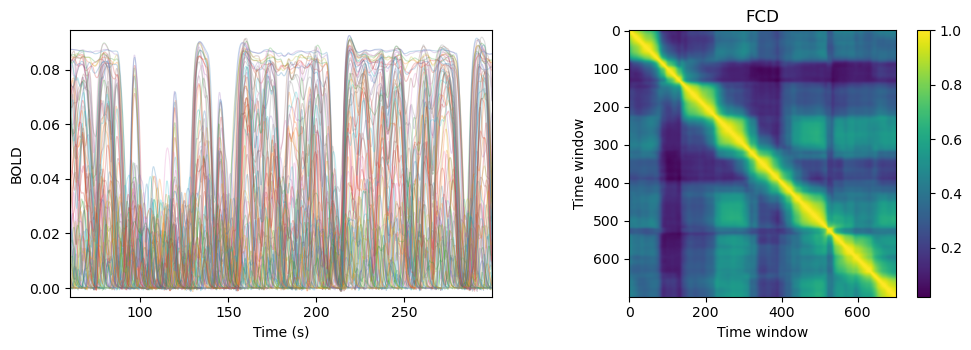

In [20]:
plot_overview(bold_t, bold_d, TR_ms=par_obs["tr"], win_len=30)

#### Prior & Training Simulations (generate or load)

Prior over G_exc

In [21]:
NUM_SIM = 200
G_MIN, G_MAX = 0.0, 2.5
prior_min = [G_MIN]
prior_max = [G_MAX]
prior = BoxUniform(low=prior_min, high=prior_max)
theta = prior.sample((NUM_SIM,), seed=SEED)   # shape: (NUM_SIM, 1)
G_exc_samples = theta[:, 0].squeeze()

Base params for training sims (we override G_exc per run)

In [22]:
par_train = dict(
    weights=W,
    nn=N_NODES,
    dt=2.5,                 # ms
    t_end=5 * 60 * 1000.0,  # ms
    t_cut=1 * 60 * 1000.0,  # ms
    G_exc=0.0,              # overridden per run
    G_inh=0.0,
    sigma=0.05,
    ext_current=0.05,
    RECORD_S=False,
    s_decimate=10,
    tr=300.0,               # ms
    seed=SEED,
)

In [23]:
TRAIN_NPZ = f"{OUT_DIR}/training_data.npz"
MASK_CSV  = f"{OUT_DIR}/remained_columns.csv"
X_PKL     = f"{OUT_DIR}/dataframe_X.pkl"

In [24]:
need_gen_train = not LOAD_DATA or not (os.path.exists(TRAIN_NPZ) and os.path.exists(MASK_CSV) and os.path.exists(X_PKL))

In [25]:
if need_gen_train:
    # Parallel feature extraction across prior samples
    feats_list = simulate_batch_ww(par_train, G_exc_samples, feat_cfg, n_workers=N_WORKERS)

    # Build DataFrame with same columns as obs features
    X_df = pd.DataFrame(np.array(feats_list).squeeze(), columns=df_obs.columns)
    X_df.to_pickle(X_PKL)

    # Keep only informative (non-near-constant) features
    keep_mask = (X_df.std() > 1e-5)
    X_df_keep = X_df.loc[:, keep_mask]
    X = X_df_keep.values.astype(np.float32)
    np.savez(TRAIN_NPZ, x=X, theta=theta)
    keep_mask.to_csv(MASK_CSV, header=["keep"], index=False)
else:
    data = np.load(TRAIN_NPZ)
    X = data["x"]
    theta = data["theta"]
    keep_mask = pd.read_csv(MASK_CSV)["keep"].astype(bool).values
    X_df = pd.read_pickle(X_PKL)

Simulating (features): 100%|██████████| 200/200 [01:53<00:00,  1.77it/s]


In [26]:
print("X shape:", X.shape, "theta shape:", theta.shape)

X shape: (200, 22) theta shape: (200, 1)


#### Feature–Parameter Scatter (Quick Diagnostic)

In [27]:
cols_kept = df_obs.columns[keep_mask]
n_features = len(cols_kept)

In [28]:
n_cols = min(5, n_features)
n_rows = int(np.ceil(min(15, n_features) / n_cols))
sel = min(15, n_features)

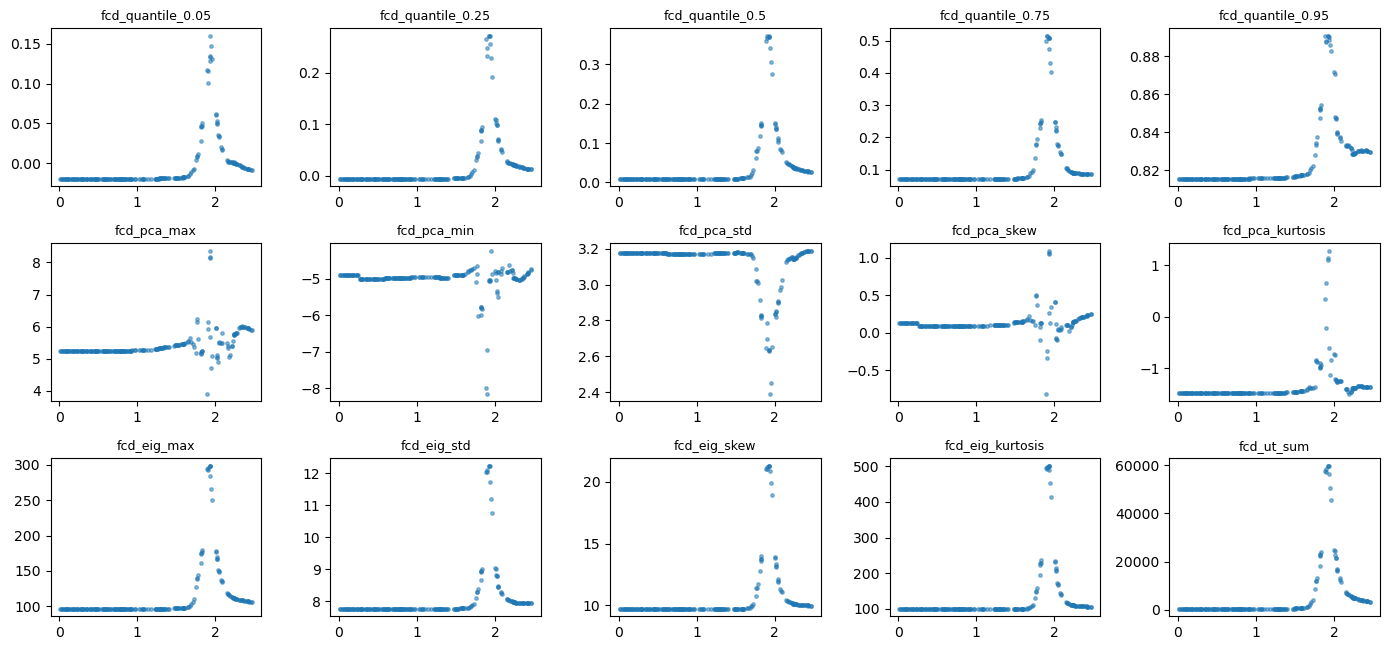

In [29]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, 2.2*n_rows))
axes = np.atleast_2d(axes)

for k in range(sel):
    i, j = divmod(k, n_cols)
    ax = axes[i, j]
    ax.scatter(theta, X[:, k], s=6, alpha=0.5)
    ax.set_title(cols_kept[k].replace("full_", ""), fontsize=9)

# Hide any unused axes
for k in range(sel, n_rows*n_cols):
    i, j = divmod(k, n_cols)
    axes[i, j].axis("off")

plt.tight_layout()
plt.show()


#### Build Observation Feature Vector (xo)

In [30]:
xo = df_obs.loc[:, cols_kept].values.astype(np.float32)
print("xo shape:", xo.shape, "| theta:", theta.shape, "| X:", X.shape)

xo shape: (1, 22) | theta: (200, 1) | X: (200, 22)


#### Train Density Estimator (MAF) & Posterior Summary

In [31]:
rng = anp.random.RandomState(SEED)
maf = MAFEstimator(n_flows=4, hidden_units=64)

Option: limit to first two features for stability (mirrors your original script)

In [32]:
X_train = X[:, :2]
xo_use = xo[:, :2]

In [33]:
maf.train(theta.astype(np.float32), X_train.astype(np.float32), n_iter=500, learning_rate=2e-4)

Inferred dimensions: param_dim=1, feature_dim=2


Training: 100%|██████████| 500/500 [00:07<00:00, 67.23it/s, patience=0/20, train=0.9182, val=1.0682] 


In [34]:
samples = maf.sample(xo_use, n_samples=5000, rng=rng)[0]
shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(theta_true, samples)

In [35]:
print("True parameters:     ", theta_true)
print("MAF mean estimate:   ", np.mean(samples, axis=0))
print("Posterior shrinkage: ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:   ", np.array2string(zscore, precision=3, separator=", "))

True parameters:      [1.9]
MAF mean estimate:    [1.9301355]
Posterior shrinkage:  [0.999]
Posterior z-score:    [1.596]


In [36]:
np.savez(f"{OUT_DIR}/samples.npz", samples=samples, xo=xo, theta_true=theta_true)

#### Posterior Plot

In [37]:
from vbi.plot import pairplot_numpy

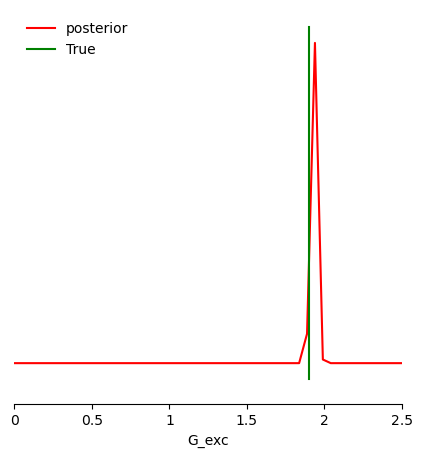

In [38]:
limits = [[lo, hi] for lo, hi in zip(prior_min, prior_max)]
fig, ax = pairplot_numpy(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=np.array(theta_true).reshape(1, -1),
    labels=["G_exc"],
    offdiag="kde",
    diag="kde",
    fig_kwargs=dict(points_offdiag=dict(marker="*", markersize=10), points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
)
plt.legend(["posterior", "True"], loc="upper left", fontsize=10, frameon=False)
fig.savefig(f"{OUT_DIR}/G_exc_posterior.png", dpi=150)